# Normal Random Forest on CICIDS2017

In [1]:
import glob
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd 
import time

from numpy import array

from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import RobustScaler

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import RandomForestClassifier

from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2

from sklearn import metrics
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_recall_fscore_support as score
from sklearn.metrics import completeness_score, homogeneity_score, v_measure_score

from sklearn.model_selection import train_test_split

## Reading data

In [2]:
# path to where ML files are stored
path = '../dataset/CICIDS2017'
all_files = glob.glob(path + "/*.csv")

# concatenate the 8 files into 1
dataset = pd.concat((pd.read_csv(f) for f in all_files))

Inspect the Dataset

In [3]:
# Peak at first 5 records in the dataset
dataset.head(5)

,Destination Port,Flow Duration,Total Fwd Packets,Total Backward Packets,Total Length of Fwd Packets,Total Length of Bwd Packets,Fwd Packet Length Max,Fwd Packet Length Min,Fwd Packet Length Mean,Fwd Packet Length Std,...,min_seg_size_forward,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Label
0,54865,3,2,0,12,0,6,6,6.0,0.0,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
1,55054,109,1,1,6,6,6,6,6.0,0.0,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
2,55055,52,1,1,6,6,6,6,6.0,0.0,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
3,46236,34,1,1,6,6,6,6,6.0,0.0,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
4,54863,3,2,0,12,0,6,6,6.0,0.0,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN


In [4]:
# get statistics about each feature
dataset.describe().transpose()

d:\Dev\Improved-RF-for-Real-time-IDS-with-Spark\venv\Lib\site-packages\pandas\core\nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)
d:\Dev\Improved-RF-for-Real-time-IDS-with-Spark\venv\Lib\site-packages\pandas\core\nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)


,count,mean,std,min,25%,50%,75%,max
Destination Port,2830743.0,8.071483e+03,1.828363e+04,0.0,53.0,80.0,443.0,65535.0
Flow Duration,2830743.0,1.478566e+07,3.365374e+07,-13.0,155.0,31316.0,3204828.5,119999998.0
Total Fwd Packets,2830743.0,9.361160e+00,7.496728e+02,1.0,2.0,2.0,5.0,219759.0
Total Backward Packets,2830743.0,1.039377e+01,9.973883e+02,0.0,1.0,2.0,4.0,291922.0
Total Length of Fwd Packets,2830743.0,5.493024e+02,9.993589e+03,0.0,12.0,62.0,187.0,12900000.0
...,...,...,...,...,...,...,...,...
Active Min,2830743.0,5.829582e+04,5.770923e+05,0.0,0.0,0.0,0.0,110000000.0
Idle Mean,2830743.0,8.316037e+06,2.363008e+07,0.0,0.0,0.0,0.0,120000000.0
Idle Std,2830743.0,5.038439e+05,4.602984e+06,0.0,0.0,0.0,0.0,76900000.0
Idle Max,2830743.0,8.695752e+06,2.436689e+07,0.0,0.0,0.0,0.0,120000000.0


In [5]:
# check all the values are numerical
# if not, would have to encode
dataset.dtypes

 Destination Port                int64
 Flow Duration                   int64
 Total Fwd Packets               int64
 Total Backward Packets          int64
Total Length of Fwd Packets      int64
                                ...   
Idle Mean                      float64
 Idle Std                      float64
 Idle Max                        int64
 Idle Min                        int64
 Label                          object
Length: 79, dtype: object

## Preprocessing data

Remove NaN/Null/Inf Values

In [6]:
dataset.isnull().any().any()

True

In [7]:
# Replace Inf values with NaN
dataset = dataset.replace([np.inf, -np.inf], np.nan)
# Drop all occurences of NaN
dataset = dataset.dropna()
# Double check these are all gone
dataset.isnull().any().any()

False

In [8]:
# rename Label columns
dataset = dataset.rename(columns={' Label': 'Label'})

In [9]:
dataset = dataset.replace(['Heartbleed', 'Web Attack � Sql Injection', 'Infiltration'], np.nan)
dataset = dataset.dropna()
dataset['Label'].value_counts()

Label
BENIGN                      2271320
DoS Hulk                     230124
PortScan                     158804
DDoS                         128025
DoS GoldenEye                 10293
FTP-Patator                    7935
SSH-Patator                    5897
DoS slowloris                  5796
DoS Slowhttptest               5499
Bot                            1956
Web Attack � Brute Force       1507
Web Attack � XSS                652
Name: count, dtype: int64

In [10]:
dataset.loc[dataset.Label == 'Web Attack � Brute Force', ['Label']] = 'Brute Force'
dataset.loc[dataset.Label == 'Web Attack � XSS', ['Label']] = 'XSS'

In [11]:
# Create attack column, containing binary labels
dataset['Attack'] = np.where(dataset['Label'] == 'BENIGN', 0, 1)
dataset['Attack'].value_counts()

Attack
0    2271320
1     556488
Name: count, dtype: int64

In [12]:
# Proposed Groupings
attack_group = {'BENIGN': 'benign', 
                'DoS Hulk': 'dos',
                'PortScan': 'probe', 
                'DDoS': 'ddos',
                'DoS GoldenEye': 'dos', 
                'FTP-Patator': 'brute_force',
                'SSH-Patator': 'brute_force', 
                'DoS slowloris': 'dos', 
                'DoS Slowhttptest': 'dos',
                'Bot': 'botnet',
                'Brute Force': 'web_attack', 
                'XSS': 'web_attack'}
# Create grouped label column
dataset['Label_Category'] = dataset['Label'].map(lambda x: attack_group[x])
dataset['Label_Category'].value_counts()

Label_Category
benign         2271320
dos             251712
probe           158804
ddos            128025
brute_force      13832
web_attack        2159
botnet            1956
Name: count, dtype: int64

## Split Data

Split data using 60:20:20 ratio, for training, test and validation dataset. We stratified so that the attack rate remained the same across all 3 sets.

In [13]:
# 3 Different labeling options
attacks = ['Label', 'Label_Category', 'Attack']

# xs=feature vectors, ys=labels
xs = dataset.drop(attacks, axis=1)
ys = dataset[attacks]

# split dataset - stratified
x_train, x_temp, y_train, y_temp = train_test_split(xs, ys, test_size=0.4, random_state=0, stratify=ys['Label'])
x_test, x_validate, y_test, y_validate = train_test_split(x_temp, y_temp, test_size=0.5, random_state=0, stratify=y_temp['Label'])


In [14]:
column_names = np.array(list(x_train))
to_drop = []
for x in column_names:
    size = x_train.groupby([x]).size()
    # check for columns that only take one value
    if (len(size.unique()) == 1):
        to_drop.append(x)
to_drop

[' Bwd PSH Flags',
 ' Bwd URG Flags',
 'Fwd Avg Bytes/Bulk',
 ' Fwd Avg Packets/Bulk',
 ' Fwd Avg Bulk Rate',
 ' Bwd Avg Bytes/Bulk',
 ' Bwd Avg Packets/Bulk',
 'Bwd Avg Bulk Rate']

Drop these because they only contain one value, and so are redundant as columns

In [15]:
x_train = x_train.drop(to_drop, axis=1)
x_validate = x_validate.drop(to_drop, axis=1)
x_test = x_test.drop(to_drop, axis=1)
dataset_copy = dataset.drop(to_drop, axis=1)

## Apply Normalization

Using minmax normalization

In [16]:
# Normalise
min_max_scaler = MinMaxScaler().fit(x_train)

# Apply normalization to dataset
x_train = min_max_scaler.transform(x_train)
x_validate = min_max_scaler.transform(x_validate)
x_test = min_max_scaler.transform(x_test)

# All values between 0 and 1
pd.Series(x_train.flatten()).describe()

count    1.187679e+08
mean     9.882020e-02
std      2.713801e-01
min      0.000000e+00
25%      0.000000e+00
50%      1.511284e-06
75%      6.410256e-03
max      1.000000e+00
dtype: float64

## Feature Selection

Use chi2 select k best First, score all the features

In [17]:
features = SelectKBest(score_func=chi2, k=x_train.shape[1])

#fit features to the training dataset
fit = features.fit(x_train, y_train.Label)

ValueError: The number of FixedLocator locations (70), usually from a call to set_ticks, does not match the number of labels (73).

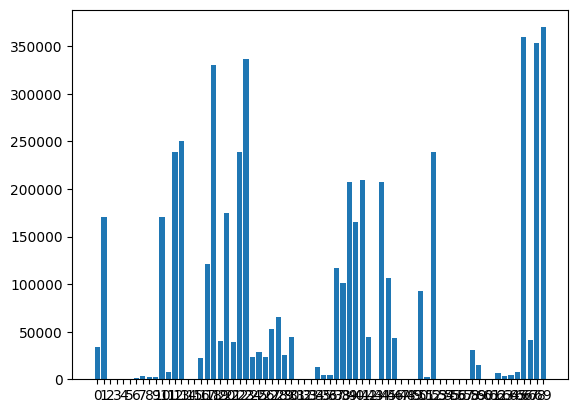

In [19]:
# plot the score associated with each feature
plt.bar([i for i in range(len(features.scores_))], features.scores_)
plt.xticks([i for i in range(len(features.scores_))], dataset_copy.columns)
plt.xticks(rotation=90, fontsize=5)
plt.tight_layout()
plt.savefig('features.png', dpi=300)

In [ ]:
# sort the features by importance score
feature_importances = zip(dataset_copy.columns, features.scores_)
feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)
sorted_importances = [importance[1] for importance in feature_importances]
sorted_features = [importance[0] for importance in feature_importances]

x_values = list(range(len(feature_importances)))

# plot the cumulative scores
cumulative_importances = np.cumsum(sorted_importances)
plt.plot(x_values, cumulative_importances)

# Draw line at 99% of importance retained 
value99 = cumulative_importances[-1]*0.99

plt.hlines(y = value99, xmin=0, xmax=len(sorted_importances), color = 'r', linestyles = 'dashed')
plt.xticks(x_values, sorted_features, rotation = 'vertical', fontsize=5)
plt.yticks([], [])
plt.xlabel('Feature Variable', fontsize=8)
plt.title('A Chart to Show Cumulative Feature Scores', fontsize=8)
#plt.figure(figsize=(500,200))
plt.tight_layout()
plt.savefig('cum_features.png', dpi=300)